In [41]:
import os
import shutil

In [208]:
source_path = os.getcwd()
source_dataset = os.path.join(source_path, 'dataset')



PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'

files = {
    'PIPELINE_CONFIG':os.path.join(source_path, 'my_modelv1', 'pipeline.config'),
    'LABELMAP': os.path.join(source_path, 'data', 'label_map.pbtxt'),
    'ANNOTATION_PATH': os.path.join(source_path, 'data'),
    'CHECKPOINT_PATH': os.path.join(source_path, 'my_modelv1'),
    'PRETRAINED_MODEL_PATH': os.path.join('pre-trained-models')
    
}

def create_dir(sourcepath):
    os.makedirs(files['CHECKPOINT_PATH'])
    
try:
    create_dir(source_path)
except FileExistsError:
    print("file already exist")

file already exist


In [89]:
print(files['PIPELINE_CONFIG'])

d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\pipeline.config


# Update Config For Transfer Learning


In [90]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [91]:
source = r'D:/BANGKIT/CAPSTONE_PROJECT/V3/pretrained_model/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'
destination = files['CHECKPOINT_PATH']
shutil.copy(source, destination)

'd:\\BANGKIT\\CAPSTONE_PROJECT\\V3\\my_modelv1\\pipeline.config'

In [92]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [93]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [94]:
labels = []
i = 0
for filename in os.listdir(source_dataset):
    i=i+1
    labels.append({'name':filename, 'id':i})

In [95]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = "D:\BANGKIT\CAPSTONE_PROJECT\V3\pretrained_model\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\checkpoint\ckpt-0"
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(files['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(files['ANNOTATION_PATH'], 'test.record')]

In [96]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# TRAINING

In [97]:
TRAINING_SCRIPT = os.path.join('d:\TFOD\Tensorflow\models','research\object_detection\model_main_tf2.py')

In [102]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=50000".format(TRAINING_SCRIPT, files['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [103]:
print(command)

#RUN LEWAT TERMINAL

python d:\TFOD\Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1 --pipeline_config_path=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\pipeline.config --num_train_steps=50000


# Evaluate the Model

In [104]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, files['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], files['CHECKPOINT_PATH'])

In [105]:
print(command)

python d:\TFOD\Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1 --pipeline_config_path=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\pipeline.config --checkpoint_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1


# Load Train Model From Checkpoint

In [209]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [210]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(files['CHECKPOINT_PATH'], 'ckpt-51')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [211]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [212]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'], use_display_name=True)

In [213]:
IMAGE_PATH = os.path.join(source_path, 'testimage')
print(IMAGE_PATH)
for i in os.listdir(IMAGE_PATH):
    print(os.path.join(IMAGE_PATH, i))

d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\bika_ambon_00000242.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\bika_ambon_00000256.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\gudeg_00000167.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\gudeg_00000177.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\gulai_ayam_00000256.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\gulai_ayam_00000261.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\kerak_telor_00000138.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\kerak_telor_00000142.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\klepon_00000070.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\klepon_00000072.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\martabak_00000142.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\martabak_00000150.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\nasi_tumpeng_00000150.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\nasi_tumpeng_00000153.jpg
d:\BANGKIT\CAPSTONE_PROJECT\V3\testimage\pecel_00000168.jpg
d:\BA

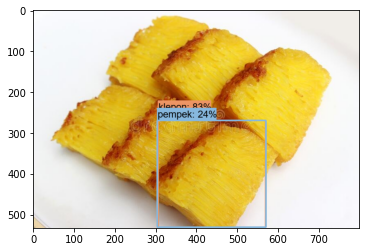

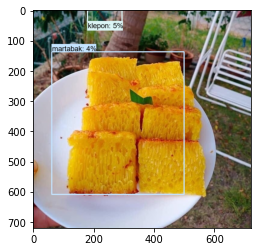

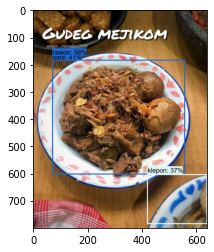

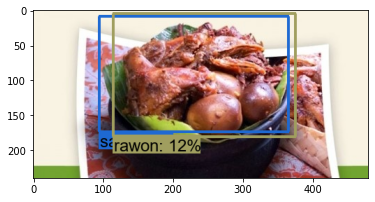

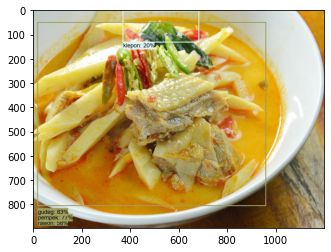

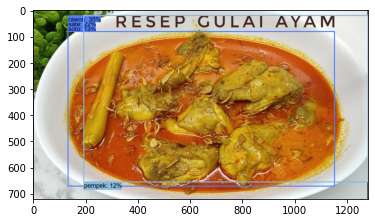

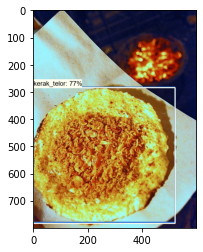

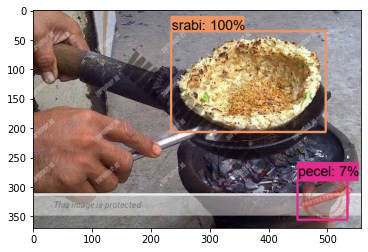

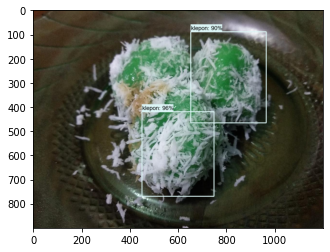

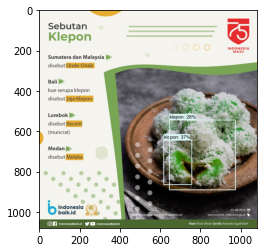

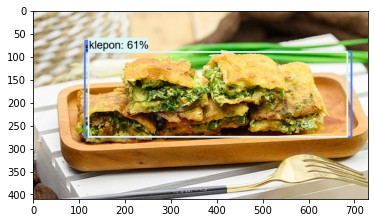

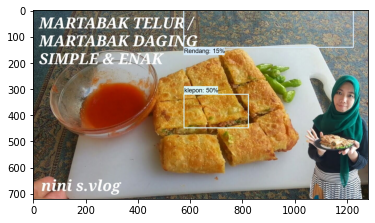

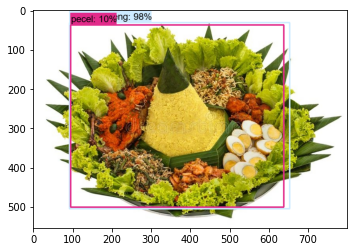

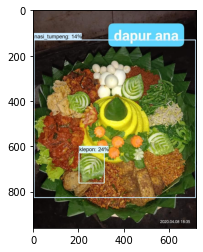

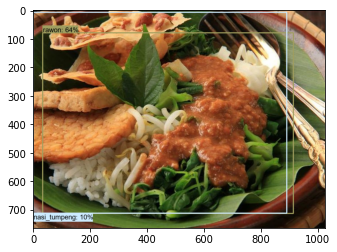

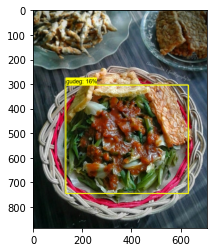

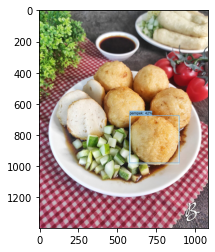

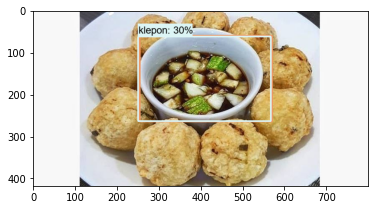

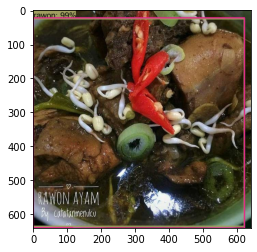

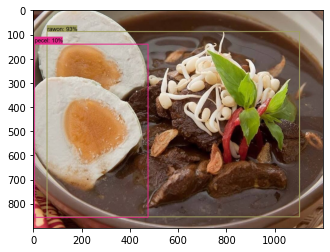

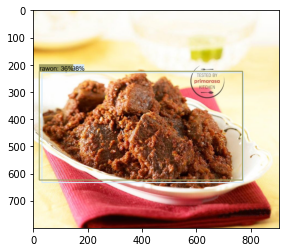

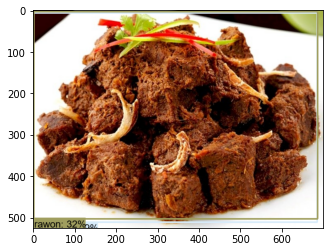

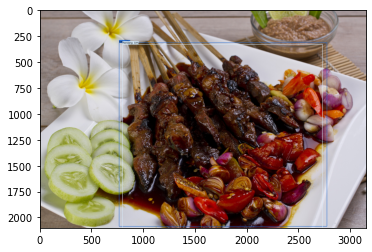

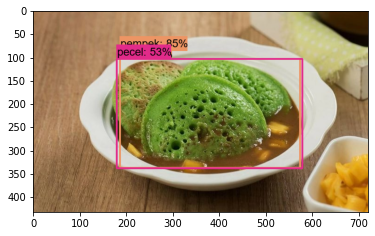

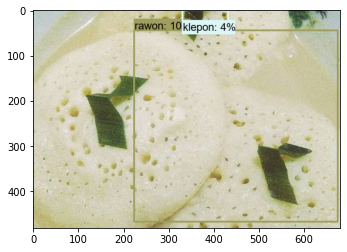

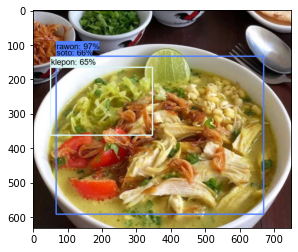

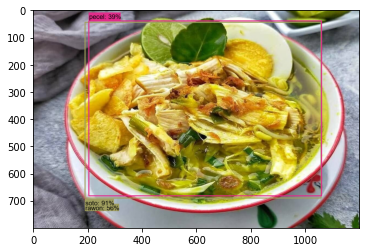

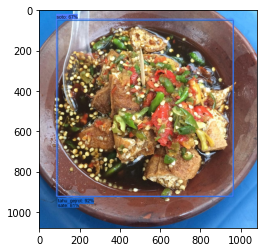

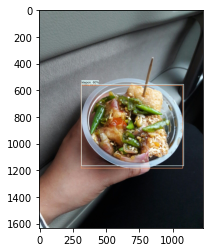

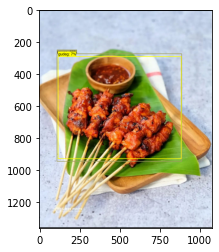

In [214]:
IMAGE_PATH = os.path.join(source_path, 'testimage')
for image_path in os.listdir(IMAGE_PATH):
    img = cv2.imread(os.path.join(IMAGE_PATH, image_path))
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=2,
                min_score_thresh=.01,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

# Freezing the Graph

In [150]:
FREEZE_SCRIPT = os.path.join('d:\TFOD\Tensorflow\models','research\object_detection\exporter_main_v2.py')

output_dir = os.path.join(source_path, files['CHECKPOINT_PATH'], 'result')
os.mkdir(output_dir)

In [151]:
print(output_dir)

d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\result


In [152]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], 'D:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1', output_dir)

In [153]:
print(command)

python d:\TFOD\Tensorflow\models\research\object_detection\exporter_main_v2.py --input_type=image_tensor --pipeline_config_path=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\pipeline.config --trained_checkpoint_dir=D:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1 --output_directory=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\result


# Conversion to TFLite

In [180]:
TFLITE_SCRIPT = os.path.join('d:\TFOD\Tensorflow\models','research\object_detection\export_tflite_graph_tf2.py ')

output_dir = os.path.join(source_path, files['CHECKPOINT_PATH'], 'tflite')
os.mkdir(output_dir)

In [181]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], files['CHECKPOINT_PATH'], output_dir)

In [182]:
print(command)

python d:\TFOD\Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\pipeline.config --trained_checkpoint_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1 --output_directory=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\tflite


In [183]:
FROZEN_TFLITE_PATH = os.path.join(output_dir, 'saved_model')
TFLITE_MODEL = os.path.join(output_dir, 'saved_model', 'detect.tflite')

In [184]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [185]:
print(command)

tflite_convert --saved_model_dir=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\tflite\saved_model --output_file=d:\BANGKIT\CAPSTONE_PROJECT\V3\my_modelv1\tflite\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops
